In [365]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [366]:
def find_subsequence(sequence, subsequence):
    idx = 0
    for char in sequence:
        if char == subsequence[idx]:
            idx += 1
        if idx == len(subsequence):
            return True
    return False

In [373]:
digits = [0, 1, 2, 3, 4, 5, 6]
padding_length = 25
n_sequences = 100000

def create_seq(baseline_in, padding_length, p=0.5, padding_symbol=8):
    baseline_length_in = len(baseline_in)
    baseline_places = []
    seq = []
    count = 0
    while count<baseline_length_in:
        if np.random.random()<p:
            digit_copy = digits.copy()
            digit_copy.remove(baseline_in[count])
            seq.append(np.random.choice(digit_copy, 1)[0])
        else:
            baseline_places.append(len(seq))
            seq.append(baseline_in[count])
            count += 1

    if len(seq) < padding_length:
        seq += [padding_symbol] * (padding_length-len(seq))
        
    return seq, baseline_places

def create_wrong_seq(padding_length, baseline_in, padding_symbol=8):
    do_again=True
    while do_again is True:
        len_seq = np.random.randint(1, 10)

        seq = np.random.choice(digits, len_seq).tolist()
        seq += [padding_symbol] * (padding_length-len(seq))
        
        do_again = find_subsequence(seq, baseline_in)
    return seq, []
    
def create_sequences(count, baseline_in):
    return map(lambda x: create_seq(baseline_in, padding_length=padding_length), range(count))


def create_wrong_sequences(count, baseline_in):
    return map(lambda x: create_wrong_seq(padding_length=padding_length, 
                                          baseline_in=baseline_in), range(count))

baseline_length = 3
right_baseline = [1,3,2]

good_list = list(create_sequences(n_sequences, right_baseline))
wrong_list = list(create_wrong_sequences(n_sequences, right_baseline))

data = good_list + wrong_list
data, places = list(map(lambda x: x[0], data)), list(map(lambda x: x[1], data))
target = [True]*n_sequences+[False]*n_sequences

good_data = good_list
good_data, places = list(map(lambda x: x[0], good_data)), list(map(lambda x: x[1], good_data))
        
data = np.array(data)
good_data = np.array(good_data)
target = np.array(target)

In [374]:
print(good_data[1946])

[2 6 0 4 6 0 3 1 6 4 3 2 8 8 8 8 8 8 8 8 8 8 8 8 8]


In [375]:
print(data[17541])

[3 3 3 2 4 2 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


In [376]:
data = data.reshape(data.shape[0], data.shape[1], 1)
print('data', data.shape)

good_data = good_data.reshape(good_data.shape[0], good_data.shape[1], 1)
print('good_data', good_data.shape)

print('target', target.shape)

data (20000, 25, 1)
good_data (10000, 25, 1)
target (20000,)


In [377]:
# Creating training and validation sets using an 80-20 split
data_train, data_val, target_train, target_val = train_test_split(data, target,
                                                                  test_size=0.05)

In [378]:
BUFFER_SIZE = len(data_train)
BATCH_SIZE = 200
steps_per_epoch = len(data_train)//BATCH_SIZE
units = 64

data_train = tf.convert_to_tensor(data_train, dtype=tf.dtypes.float32)
good_data = tf.convert_to_tensor(good_data, dtype=tf.dtypes.float32)
data = tf.convert_to_tensor(data, dtype=tf.dtypes.float32)
target_train = tf.convert_to_tensor(target_train, dtype=tf.dtypes.float32)

dataset = tf.data.Dataset.from_tensor_slices((data_train, target_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [379]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units), dtype=tf.dtypes.float32)

In [380]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([200, 25, 1]), TensorShape([200]))

In [381]:
encoder = Encoder(units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (200, 25, 64)
Encoder Hidden state shape: (batch size, units) (200, 64)


In [382]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, sequence_length, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, sequence_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [383]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (200, 64)
Attention weights shape: (batch_size, sequence_length, 1) (200, 25, 1)


In [384]:
class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        #     self.fc = tf.keras.layers.Dense(1)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([context_vector, x], axis=-1)
        x = tf.expand_dims(x, 1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        x = tf.reshape(output, (-1, output.shape[2]))

        return x, state, attention_weights

In [385]:
class Classifier(tf.keras.Model):
    def __init__(self, batch_sz):
        super(Classifier, self).__init__()
        self.batch_sz = batch_sz
        self.fc1 = tf.keras.layers.Dense(32, activation='tanh')
        self.fc4 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.fc1(x)
        x = self.fc4(x)
        return x

In [386]:
decoder = Decoder(units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (200, 64)


In [387]:
classifier = Classifier(BATCH_SIZE)

In [388]:
optimizer = tf.keras.optimizers.Adam()

loss_fn = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)

In [389]:
@tf.autograph.experimental.do_not_convert
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        all_out_dec = []

        # Teacher forcing - feeding the target as the next input
        for t in range(0, inp.shape[1]):
            dec_input = inp[:, t, :]
            out_dec, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            all_out_dec.append(out_dec)
            
        all_out_dec = tf.concat(all_out_dec, axis=-1)
        prediction = classifier(all_out_dec)

        loss = loss_fn(prediction, targ)
        batch_loss = (loss / int(inp.shape[1]))
        variables = encoder.trainable_variables + decoder.trainable_variables + classifier.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss, prediction

In [397]:
EPOCHS = 10
Acc_class = tf.keras.metrics.Accuracy(name="accuracy", dtype=None)

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    all_acc = []
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss, prediction = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        acc_batch = Acc_class(np.round(prediction), targ)
        all_acc.append(acc_batch)

    print('Epoch {} Loss {} Acc {}'.format(epoch + 1, total_loss / steps_per_epoch, 
                                           np.mean(all_acc)))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 0.04371343553066254 Acc 0.9396596550941467
Time taken for 1 epoch 46.92895007133484 sec

Epoch 2 Loss 0.019535483792424202 Acc 0.9396541118621826
Time taken for 1 epoch 54.2650363445282 sec

Epoch 3 Loss 0.01553440187126398 Acc 0.9538410902023315
Time taken for 1 epoch 60.58668780326843 sec

Epoch 4 Loss 0.015768110752105713 Acc 0.9601109623908997
Time taken for 1 epoch 58.76879143714905 sec

Epoch 5 Loss 0.012362102046608925 Acc 0.9636350274085999
Time taken for 1 epoch 46.2893443107605 sec

Epoch 6 Loss 0.013626608066260815 Acc 0.9667780995368958
Time taken for 1 epoch 45.638553619384766 sec

Epoch 7 Loss 0.014852236025035381 Acc 0.9681528806686401
Time taken for 1 epoch 45.63822674751282 sec

Epoch 8 Loss 0.05081391707062721 Acc 0.9670646786689758
Time taken for 1 epoch 47.37821435928345 sec

Epoch 9 Loss 0.03583740070462227 Acc 0.9604979157447815
Time taken for 1 epoch 51.84011173248291 sec

Epoch 10 Loss 0.016284482553601265 Acc 0.9607878923416138
Time taken for 1 epo

In [391]:
def evaluate(sequence):
    attention_plot = np.zeros((padding_length, padding_length))
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(sequence, hidden)

    dec_hidden = enc_hidden
    all_out_dec = []

    for t in range(0, padding_length):
        dec_input = sequence[:, t, :]
        out_dec, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        all_out_dec.append(out_dec)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

    all_out_dec = tf.concat(all_out_dec, axis=-1)
    result = classifier(all_out_dec)

    return result, sequence, attention_plot

In [392]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels(np.roll(sentence, 1), fontdict=fontdict)
    ax.set_yticklabels(np.roll(sentence, 1), fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [393]:
print(data.shape)
print(good_data.shape)

(20000, 25, 1)
(10000, 25, 1)


In [394]:
def get_attention(idx):
    sequence = tf.expand_dims(good_data[idx], 0)

    result, sentence, attention_plot = evaluate(sequence)
    seq_numpy = sequence.numpy()
    seq_numpy = seq_numpy.reshape(-1)
    
    plot_attention(attention_plot, seq_numpy, seq_numpy)

<ipython-input-392-02e7a5da5daf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.roll(sentence, 1), fontdict=fontdict)
<ipython-input-392-02e7a5da5daf>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.roll(sentence, 1), fontdict=fontdict)


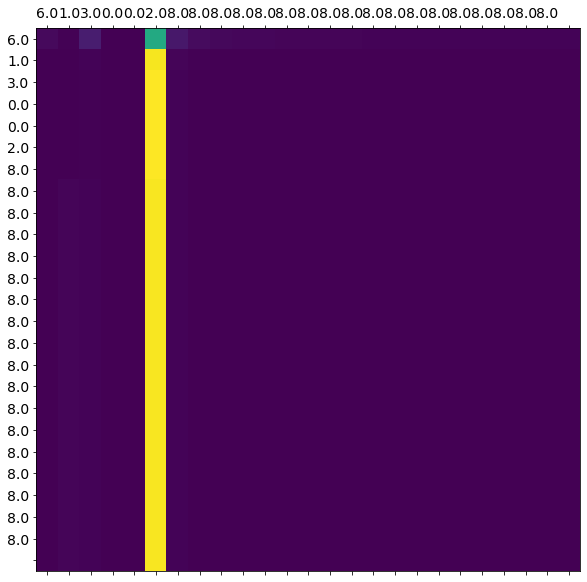

In [404]:
get_attention(idx=150)